In [5]:
# import libraries
import os
import glob
import math
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
import plotly.express as px
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import folium
import data_utils
plt.style.use('ggplot')

## Load Raw Data

In [2]:
# load csv raw data and save it to parquet
raw_data = pd.read_csv("raw_data/raw_crashes_2019_2021.csv")
raw_data.to_parquet("data/raw_crashes_2019_2021.csv")


In [3]:
# load parquet
raw_data = pd.read_parquet("data/raw_crashes_2019_2021.csv")

In [4]:
raw_data.head(5)

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,8168138,2019,2020-01-28,3000,2019-08-30,1600,3358,972D1,5,5,...,0,0,-,-,NaN,NaN,ORANGE,SAN JUAN CAPISTRANO,-117.656082,33.503235
1,8806652,2019,2019-07-18,3000,2019-02-17,700,9220,972D1,7,5,...,0,0,-,SF,NaN,NaN,ORANGE,SAN JUAN CAPISTRANO,-117.658058,33.502583
2,8833557,2019,2019-07-18,3000,2019-03-23,2151,2647,952G6,6,5,...,0,0,-,-,NaN,NaN,ORANGE,SAN JUAN CAPISTRANO,-117.633255,33.514874
3,8843043,2019,2019-08-23,3000,2019-04-02,1535,9220,952F6,2,5,...,0,0,-,-,NaN,NaN,ORANGE,SAN JUAN CAPISTRANO,-117.634476,33.514515
4,8869822,2019,2019-08-27,3000,2019-04-19,1610,3358,972D1,5,5,...,0,0,-,-,NaN,NaN,ORANGE,SAN JUAN CAPISTRANO,-117.655632,33.503399


In [13]:
len(raw_data)

148

In [32]:
SR74_postmile_gdf = gpd.read_parquet("data/SR74_postmile_gdf.parquet")

In [33]:
len(SR74_postmile_gdf)

170

In [34]:
SR74_postmile_gdf.head(5)

,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ALIGNCODE,Lat_WGS84,Long_WGS84,geometry
576,258722,74,74_20171231_R,ORA,12,None,11.300000,None,11.3,Right,33.580740,-117.529616,POINT (-117.52962 33.58074)
577,258737,74,74_20171231_R,ORA,12,None,3.000000,None,3,Right,33.521904,-117.613456,POINT (-117.61346 33.52190)
581,259040,74,74_20171231_R,ORA,12,None,16.599001,None,16.599,Right,33.602202,-117.457767,POINT (-117.45777 33.60220)
584,259362,74,74_20171231_R,ORA,12,None,8.800000,None,8.8,Right,33.551094,-117.548974,POINT (-117.54897 33.55109)
585,259585,74,74_20171231_R,ORA,12,None,11.600000,None,11.6,Right,33.582667,-117.525100,POINT (-117.52510 33.58267)


## Data Wrangling and Spatial Analysis

In [6]:
raw_data.columns

Index(['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE',
       'COLLISION_TIME', 'OFFICER_ID', 'REPORTING_DISTRICT', 'DAY_OF_WEEK',
       'CHP_SHIFT', 'POPULATION', 'CNTY_CITY_LOC', 'SPECIAL_COND', 'BEAT_TYPE',
       'CHP_BEAT_TYPE', 'CITY_DIVISION_LAPD', 'CHP_BEAT_CLASS', 'BEAT_NUMBER',
       'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION',
       'WEATHER_1', 'WEATHER_2', 'STATE_HWY_IND', 'CALTRANS_COUNTY',
       'CALTRANS_DISTRICT', 'STATE_ROUTE', 'ROUTE_SUFFIX', 'POSTMILE_PREFIX',
       'POSTMILE', 'LOCATION_TYPE', 'RAMP_INTERSECTION', 'SIDE_OF_HWY',
       'TOW_AWAY', 'COLLISION_SEVERITY', 'NUMBER_KILLED', 'NUMBER_INJURED',
       'PARTY_COUNT', 'PRIMARY_COLL_FACTOR', 'PCF_CODE_OF_VIOL',
       'PCF_VIOL_CATEGORY', 'PCF_VIOLATION', 'PCF_VIOL_SUBSECTION',
       'HIT_AND_RUN', 'TYPE_OF_COLLISION', 'MVIW', 'PED_ACTION',
       'ROAD_SURFACE', 'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING',
       'CONTROL_DEVICE', 'CHP_ROAD_TYPE', 'PEDESTRIAN_

In [12]:
raw_data['CASE_ID'].nunique()

148

In [19]:
cols_to_keep = [
    "CASE_ID",
    "ACCIDENT_YEAR",
    "DIRECTION",
    "POSTMILE",
    "COLLISION_SEVERITY",
    "NUMBER_KILLED",
    "NUMBER_INJURED",
    "PRIMARY_COLL_FACTOR",
    "TYPE_OF_COLLISION",
    "PEDESTRIAN_ACCIDENT",
    "BICYCLE_ACCIDENT",
    "MOTORCYCLE_ACCIDENT",
    "TRUCK_ACCIDENT",
    "ALCOHOL_INVOLVED",
    "POINT_X",
    "POINT_Y",
]


In [20]:
TIMS_trimmed_df = raw_data.loc[:, cols_to_keep]

In [24]:
print(TIMS_trimmed_df["POINT_X"].isna().sum())
print(TIMS_trimmed_df["POINT_Y"].isna().sum())

0
0


In [25]:
TIMS_trimmed_df = TIMS_trimmed_df.rename(columns={
    "POINT_X": "lon",
    "POINT_Y": "lat",
})

In [26]:
TIMS_trimmed_gdf = data_utils.coordinate_to_geometry(TIMS_trimmed_df)

In [27]:
TIMS_trimmed_gdf.head(5)

,CASE_ID,ACCIDENT_YEAR,DIRECTION,POSTMILE,COLLISION_SEVERITY,NUMBER_KILLED,NUMBER_INJURED,PRIMARY_COLL_FACTOR,TYPE_OF_COLLISION,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,ALCOHOL_INVOLVED,lon,lat,geometry
0,8168138,2019,E,0.160,3,0,2,A,A,NaN,None,None,None,None,-117.656082,33.503235,POINT (-117.65608 33.50323)
1,8806652,2019,None,0.029,4,0,1,A,D,NaN,None,None,Y,None,-117.658058,33.502583,POINT (-117.65806 33.50258)
2,8833557,2019,None,1.711,3,0,2,A,D,NaN,None,None,None,None,-117.633255,33.514874,POINT (-117.63326 33.51487)
3,8843043,2019,E,1.640,3,0,1,A,E,NaN,None,None,None,None,-117.634476,33.514515,POINT (-117.63448 33.51451)
4,8869822,2019,W,0.190,4,0,2,A,C,NaN,None,None,None,None,-117.655632,33.503399,POINT (-117.65563 33.50340)


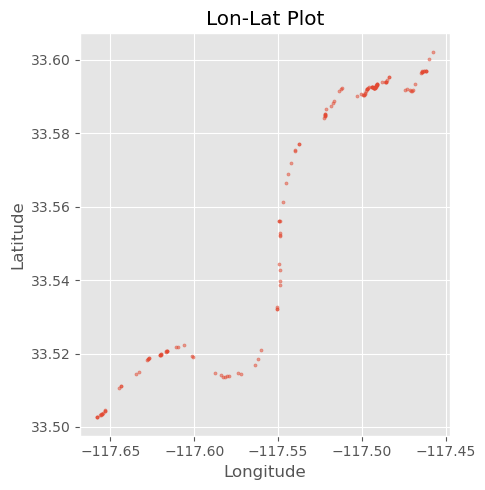

In [30]:
import matplotlib.pyplot as plt

# create plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(TIMS_trimmed_gdf['lon'], TIMS_trimmed_gdf['lat'], s=5, alpha=0.5)

# add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Lon-Lat Plot')

# display the plot
fig.tight_layout()
plt.show()
